In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src")

In [3]:
from CompoTree import ComponentTree, Radicals, TSVariants, CharLexicon

In [96]:
from gensim.models.keyedvectors import KeyedVectors
kv = KeyedVectors.load("../data/fasttext-zh-sw/fasttext-zh-sw.kv")
kv.init_sims()

In [61]:
ctree = ComponentTree.load()
radicals = Radicals.load()
tsvars = TSVariants.load()
lexicon = CharLexicon.load()


In [62]:
ctree.query("灘", use_flag="first")[0].children

[['氵'], [<⿰:[<⿱:廿⿻口夫>]['隹'](GTKV)>]]

In [63]:
for w in lexicon:
    print(w)
    break

蹑


In [146]:
from collections import defaultdict
chars_set = set()
compo_set = set()
decompo_set = set()
compo_items = set()
for word in lexicon:  
    if word not in kv.vocab:
        continue
        
    try:
        ortho_x = ctree.query(word, 
                          max_depth=1, 
                          use_flag="shortest")[0]
    except:
        print(word)
        continue
            
    if isinstance(ortho_x, str):
        compos = [ortho_x]
    else:
        compos = [str(x) for x in 
                  ortho_x.components(use_flag="shortest")]
        
    compo_seq = tuple(sorted(compos))     
    if compo_seq not in compo_items and len(compos) == 2:
        compo_items.add(compo_seq)
    else:        
        continue
    
    chars_set.add(word)    
    if tsvars.is_traditional(word):
        compos = [x+"_t" for x in compos]
    else:
        compos = [x+"_s" for x in compos]
       
    compo_set |= set(compos)
    decompo_set |= set((word, str(compo_x))
                       for compo_x in compos)    

In [132]:
len(chars_set), len(compo_set), len(decompo_set)

(6156, 2561, 12292)

In [133]:
sorted(list(decompo_set), key=lambda x: x[0])[:20]

[('丁', '亅_s'),
 ('丁', '一_s'),
 ('七', '乚_s'),
 ('七', '㇀_s'),
 ('万', '一_s'),
 ('万', '⿰丿𠃌_s'),
 ('三', '一_s'),
 ('三', '二_s'),
 ('上', '一_s'),
 ('上', '⺊_s'),
 ('下', '一_s'),
 ('下', '卜_s'),
 ('丕', '一_s'),
 ('丕', '不_s'),
 ('丙', '一_s'),
 ('丙', '内_s'),
 ('丛', '一_s'),
 ('丛', '从_s'),
 ('丝', '一_s'),
 ('丝', '⿰②②_s')]

## Component Matrix

In [134]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [135]:
char_enc = LabelEncoder()
compo_enc = LabelEncoder()
char_enc.fit(list(chars_set))
compo_enc.fit(list(compo_set))

LabelEncoder()

In [136]:
n_char = len(char_enc.classes_)
n_compo = len(compo_enc.classes_)

In [137]:
decompo_matrix = np.zeros((n_char, n_compo), dtype=np.int32)
decompo_matrix.shape

(6156, 2561)

In [138]:
for item_x in decompo_set:
    char_idx = char_enc.transform([item_x[0]])[0]
    compo_idx = compo_enc.transform([item_x[1]])[0]
    decompo_matrix[char_idx, compo_idx] = 1

In [158]:
aa = LabelEncoder()
aa.fit(["a", "b", "c"])

LabelEncoder()

In [163]:
sel_compo_idx = decompo_matrix.sum(axis=0)>1
sel_compo_enc = LabelEncoder()
sel_compo_enc.fit(compo_enc.classes_[sel_compo_idx])
decompo_matrix_reduced = decompo_matrix[:, sel_compo_idx]
print(decompo_matrix_reduced.shape)
la.matrix_rank(decompo_matrix_reduced)

(6156, 1369)


1369

In [161]:
## Character semantic vector
word_kv_idxs = []
for word in char_enc.classes_:
    word_kv_idxs.append(kv.vocab[word].index)
char_ft = kv.vectors_norm[word_kv_idxs, :]
char_ft.shape

(6156, 300)

## Component semantic matrix
$$
C_{k\times d}: \textrm{Component semantic matrix, k components $\times$ d vector size }\\
Z_{n\times d}: \textrm{Character semantic matrix, n characters $\times$ d vector size }\\
D_{n\times k}: \textrm{Decomposition matrix, n characters $\times$ k components}\\
Z = D\cdot C\\
C = (D^\top D)^{-1}D^\top Z
$$

In [164]:
import numpy as np
import numpy.linalg as la

D = decompo_matrix_reduced
Z = char_ft
print("D, Z: ", D.shape, Z.shape)
compo_ft = la.inv(D.T.dot(D)).dot(D.T).dot(Z)

D, Z:  (6156, 1369) (6156, 300)


In [183]:
Zhat = D.dot(compo_ft)
R = np.corrcoef(Z, Zhat)

In [196]:
Rn[~nan_rows_idx, :][:, ~nan_rows_idx].shape

(6104, 6104)

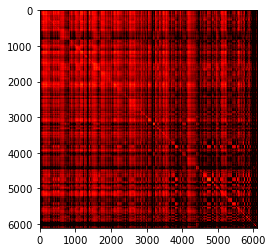

In [200]:
Rn = R[:Z.shape[0], Z.shape[0]:]
nan_rows_idx = np.isnan(Rn).any(axis=0)
plt.imshow(Rn[~nan_rows_idx, :][:, ~nan_rows_idx], cmap="hot", vmin=.90)

In [208]:
la.norm(Z, axis=1).shape

(6156,)

In [210]:
def query_component(compo, is_trad=True):
    compo = compo + ("_t" if is_trad else "_s")
    compo_vec = compo_ft[sel_compo_enc.transform([compo])[0]]
    return compo_vec

In [213]:
kv.similar_by_vector(query_component("又", is_trad=True))

[('雙', 0.9749046564102173),
 ('馭', 0.9748619794845581),
 ('隻', 0.9687663316726685),
 ('兩', 0.9605927467346191),
 ('單', 0.9604883790016174),
 ('則', 0.9590445160865784),
 ('與', 0.9579811096191406),
 ('並', 0.9563131928443909),
 ('爲', 0.9559267163276672),
 ('將', 0.9556430578231812)]

In [214]:
kv.similar_by_vector(query_component("又", is_trad=False))

[('则', 0.9889439344406128),
 ('却', 0.9887244701385498),
 ('对', 0.9873088002204895),
 ('与', 0.9872829914093018),
 ('当', 0.9870806932449341),
 ('虽', 0.9868679642677307),
 ('说', 0.986778974533081),
 ('并', 0.9860985279083252),
 ('还', 0.9857279062271118),
 ('将', 0.985576868057251)]